# **Application Exploratory Data Analysis**

## **Table of contents**
* [Our goals](#Our-goals)
* [About-the-data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Features description](#Features-description)
    * [Target variables](#Target-variable)
    * [Numerical features](#Numerical-features)
        * [`CNT_FAM_MEMBERS` and `CNT_CHILDREN`](#`CNT_FAM_MEMBERS`-and-`CNT_CHILDREN`)
        * [Entourage Default Block](#Entourage-Default-Block)
        * [Housing Statistics Block](#Housing-Statistics-Block)
        * [Numerical features distribution](#Numerical-features-distribution)
    * [Categorical features](#Categorical-features)
        * [Entropy](#Entropy)
        * [Categorical features distribution](#Categorical-features-distribution)
* [Preliminary model](#Preliminary-model)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    stat_utilities,
    plot_utilities
)

from utilities.plot_utilities import (
    to_percent,
    plot_triangle_corr_matrix,
    Rstyle_spines,
    multicolumn_barplot,
    plot_num_vs_target,
    set_to_percent,
)
from utilities.stat_utilities import (
    get_missing_values,
    conditional_cramersV,
    corr_cramersV,
    calculate_cat_entropy
)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn import set_config

set_config(transform_output="pandas")
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, TargetEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.set_option("display.max_columns", 300)

In [2]:
data_dir = "../sample_data/"
sample_application = pd.read_parquet(data_dir + "sample_application.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">

Our goals here, ranked by their respective priority, are to:
* **Understand the dataframe's structure:** Gain a comprehensive overview of the dataframe, including its complexity, distribution of values, and potential challenges such as missing data or inconsistencies.
* **Identify key features:** Determine which features are most relevant to the task, focusing on those that have the strongest impact on the target variable or add meaningful value to the model.
* **Reduce dimensionality:** Simplify the dataset by reducing the number of features, using techniques such as removing multicollinear variables or irrelevant features, while ensuring model performance is maintained or improved.
* **Build a baseline classifier:** Create an initial classifier using the dataset, which will serve as a benchmark for evaluating future improvements through feature engineering and model refinement.
</div>

## **About the data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Each individual seeking a loan from Home Credit is required to fill out a form that helps the company create a preliminary profile of the applicant. This information primarily focuses on establishing the applicant’s financial profile. 
</div>

## **Generalities**

In [3]:
sample_application.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61502 entries, 213296 to 216837
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float32(64), float64(1), int16(2), int32(2), int8(37)
memory usage: 19.8 MB


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
There are 122 features, which is quite a lot. One of the initial challenges will be to identify which features are truly relevant for the task at hand. A good strategy to simplify the dataset would be to eliminate features that are either highly correlated with each other (multicollinearity) or those that are poorly related to the target variable.
</br> </br>
However, it's important to note that a feature that isn't strongly correlated with the target variable on its own may still be valuable when combined with other features. Indeed, these combinations could enhance our prediction performance. 
</div>

## **Missing values**

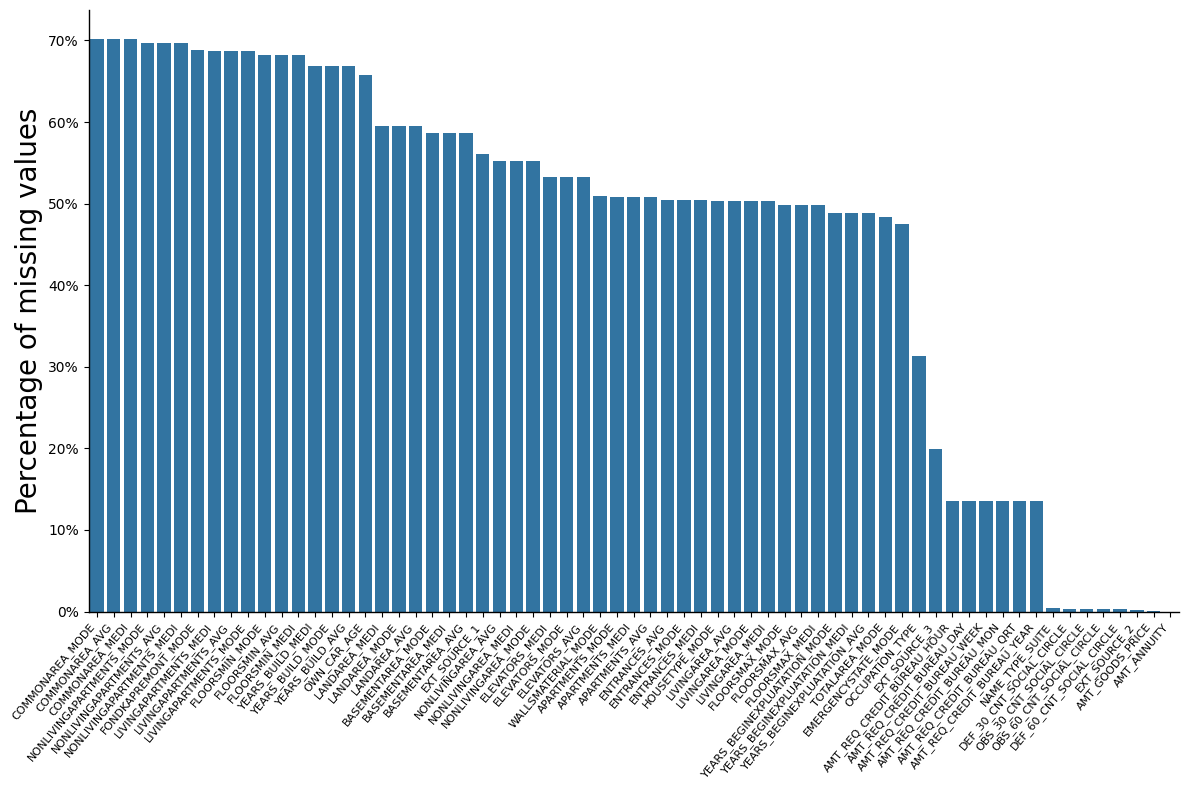

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
app_na = get_missing_values(sample_application)
app_na = app_na[app_na["Count"] > 0]
sns.barplot(app_na, x=app_na.index, y="Percent", ax=ax)
Rstyle_spines(ax, lw=1)
ax.set_xticks(range(0, len(app_na.index)))
ax.set_xticklabels(app_na.index, rotation=50, ha="right", fontsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_xlabel("")
ax.set_ylabel("Percentage of missing values", fontsize=20)
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Our dataframe contains a significant amount of missing values, with some features having more than 70% missing data. However, before discarding any of these features solely based on their missing value proportions, we want to first determine if they could contribute to improving our model's performance. We will continue by carefully analyzing each of these features, and when the time comes, we'll need to apply smart imputation techniques to handle the missing values effectively.
</div>

## **Features description**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

In this section, we'll focus on gathering detailed information about each feature in the dataset. Given the large number of features, we’ll employ **Kendall** correlation for numerical features and **Chi-squared tests combined with Cramér's V** for categorical features. This will allow us to quantify how these features relate to each other and to the target variable. This approach will also help us identify potential redundancy between features, enabling us to reduce the dataset's dimensionality. Additionally, we’ll use **entropy** to assess whether certain categorical variables provide meaningful information or are potentially irrelevant.
</div>

### **Target variable**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Our first goal is to understand how our target variable is distributed. This will provide crucial insights into the balance or imbalance in the dataset and help us define appropriate strategies to improve our classifier's performance. Understanding the distribution will also guide us in selecting techniques such as resampling or using performance metrics that are better suited for imbalanced data, if necessary.
</div>

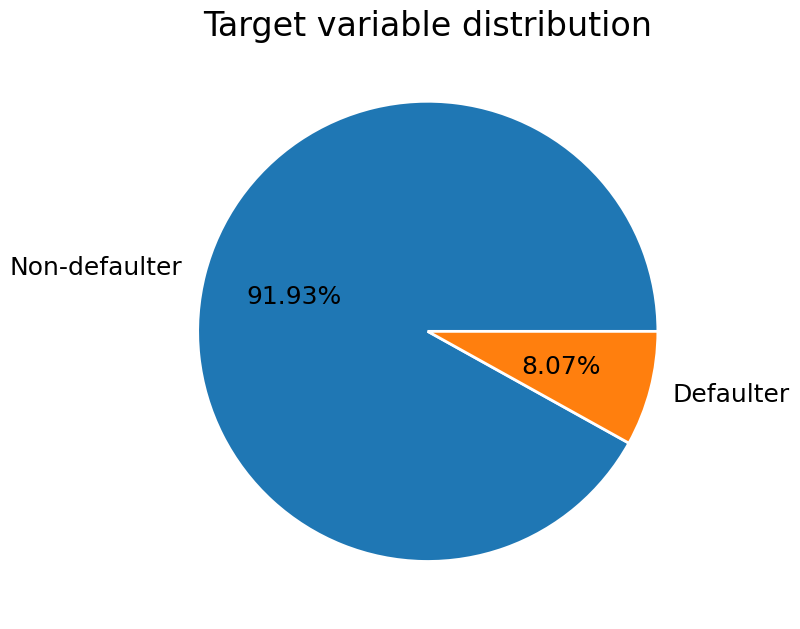

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    sample_application["TARGET"].value_counts(),
    labels=["Non-defaulter", "Defaulter"],
    autopct=lambda p: f"{p:.2f}%",
    wedgeprops={"edgecolor": "white", "lw": 2},
    textprops={"fontsize": 18},
)
ax.set_title("Target variable distribution", fontsize=24)
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

There is a significant imbalance in our target variable, with applicants who will default (`TARGET` = 1) representing only 8.07% of the total. As a result, we will need to use algorithms that are sensitive to imbalanced data. While resampling techniques such as oversampling or undersampling could be considered, they often underperform compared to algorithms specifically designed to handle this challenge, such as **XGBoost**, **LightGBM**, or using class weighting in models like **Random Forest** and **Logistic Regression**.
Additionally, we will use the **ROC AUC** (Receiver Operating Characteristic Area Under the Curve) metric, which is ideal for handling imbalanced datasets. The ROC AUC measures the model's ability to distinguish between classes, providing a more comprehensive evaluation of performance compared to simple accuracy, especially when the classes are imbalanced. This will help us better assess how well the model is predicting defaults versus non-defaults.
</div>

### **Numerical features**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We'll start by analyzing the numerical features. For this analysis, we'll exclude features that are binary flags (containing only 0 or 1) or those with a very limited range of values, as these will be treated later with the categorical features. This initial focus will help us understand the relationships and patterns among the numerical variables and their impact on the target variable.
</div>

In [6]:
app_num_cols = [
    col
    for col in sample_application.select_dtypes(include="number").columns
    if not col.startswith(("FLAG_", "REG_", "LIVE_", "REGION_RATING_", "SK_ID_CURR"))
]

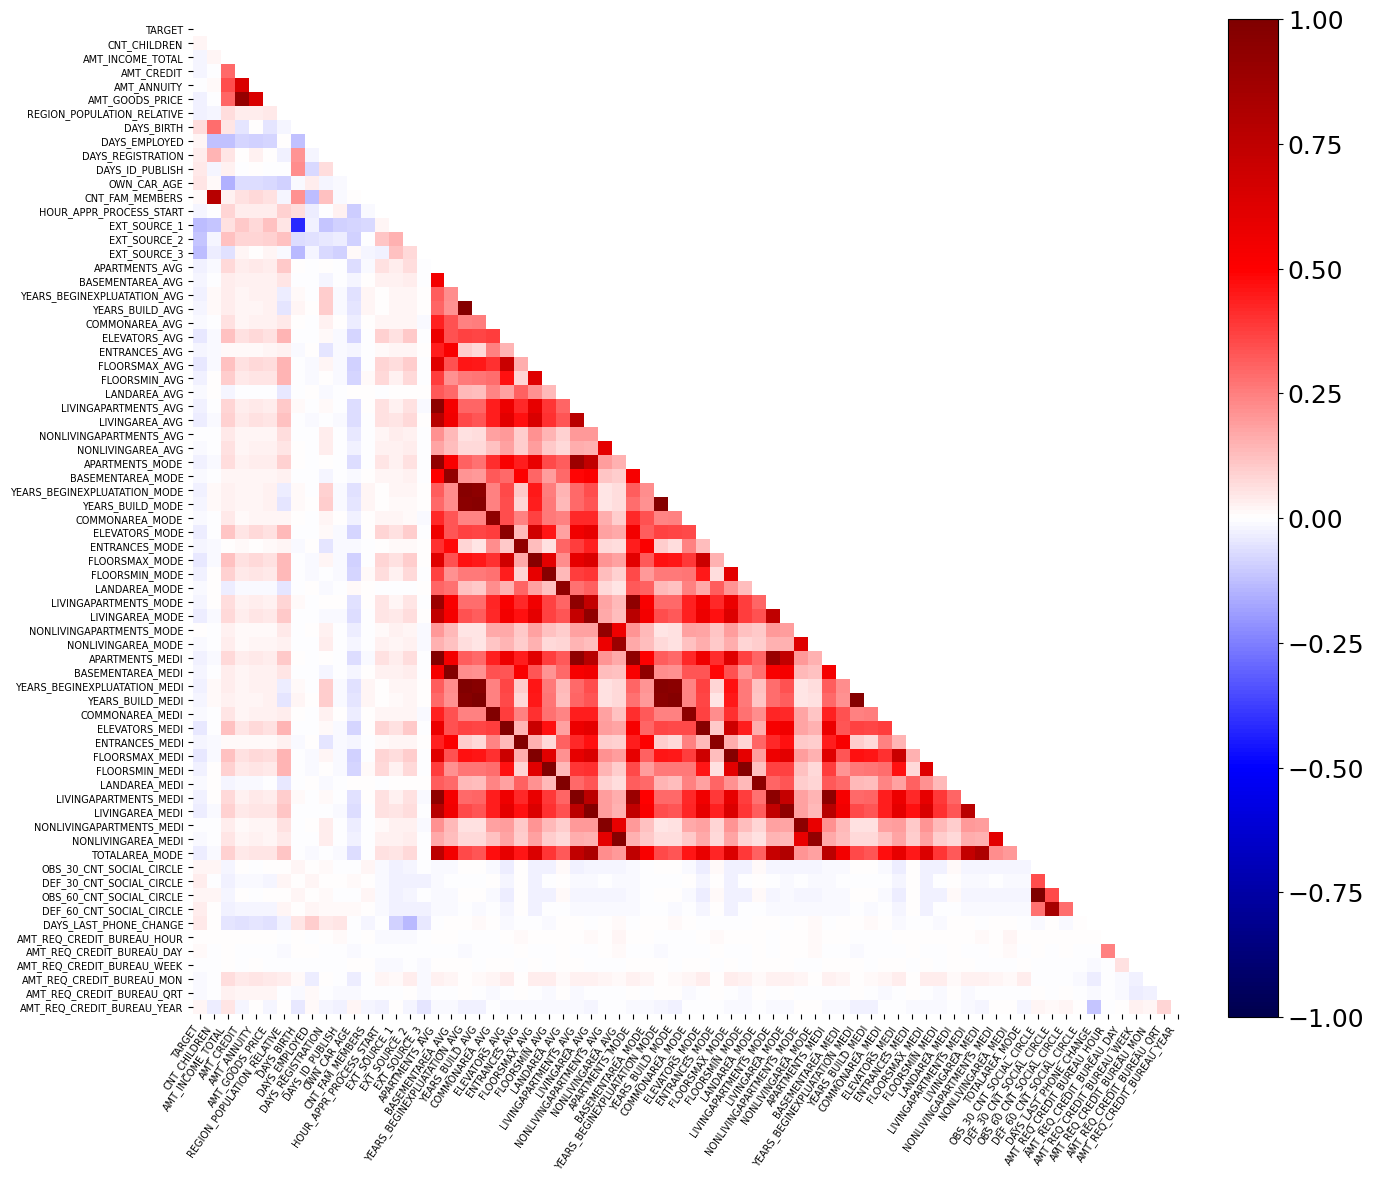

In [7]:
num_corr = sample_application[app_num_cols].corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=7)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

From the correlation heatmap, we observe the following:

* **Housing Statistics Block:** There is a block of features highly correlated with each other, all related to the housing statistics of the loan applicant. This block includes the mode, average, and median values for the same housing feature. This redundancy poses a risk of multicollinearity and overfitting. Arbitrarily removing some of these features could result in loss of valuable information. Therefore, we will first impute these features, rescale them, and then apply Principal Component Analysis (PCA) to retain 90% of the information within this subset.
* **Amount-Related Features:** We observe that the four quantities related to the amount are naturally very correlated. Despite their high correlation, these features are likely crucial for predicting whether a loan applicant is prone to default. They provide essential information on various aspects of the applicant's financial situation such as: the total amount of the loan, `AMT_CREDIT`, the payment amount required for the loan, `AMT_ANNUITY`, the applicant’s financial capacity or stability, `AMT_INCOME_TOTAL` and the cost of the goods or services being financed by the loan, `AMT_GOODS_PRICE`.
* **`CNT_FAM_MEMBERS` and `CNT_CHILDREN`:** These features are naturally highly correlated. We may consider dropping one of them to simplify the model and reduce redundancy.
* **Entourage Default Block:** There is another block of features related to the loan applicant’s entourage who have already defaulted. We will examine these features in detail and determine appropriate measures to address them.

</div>

#### **`CNT_FAM_MEMBERS` and `CNT_CHILDREN`**

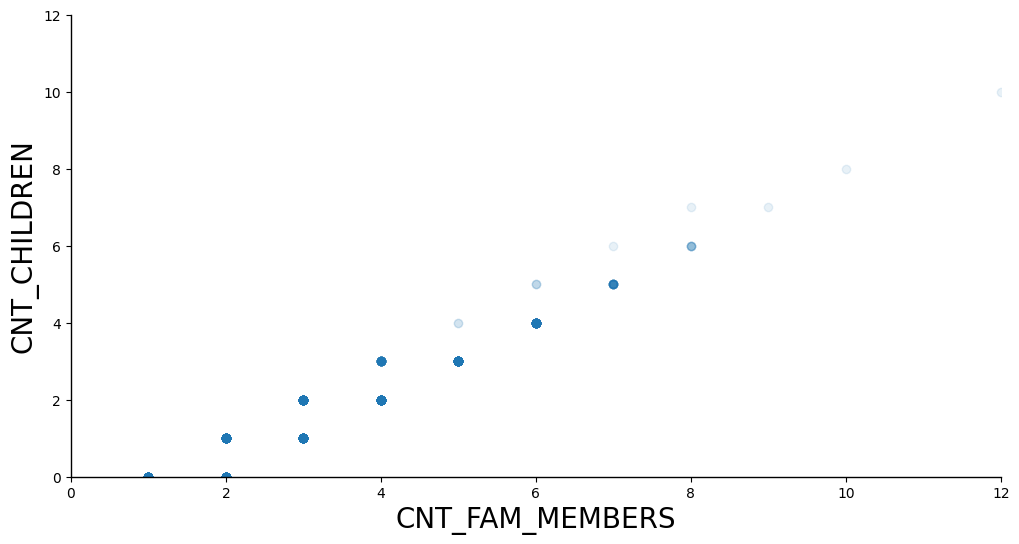

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    sample_application["CNT_FAM_MEMBERS"], sample_application["CNT_CHILDREN"], alpha=0.1
)
ax.set_xlabel("CNT_FAM_MEMBERS", fontsize=20)
ax.set_ylabel("CNT_CHILDREN", fontsize=20)
ax.set_xlim((0, 12))
ax.set_ylim((0, 12))
Rstyle_spines(ax, lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As expected, there is an obvious linear relationship between the two features. We can decide to keep the `CNT_CHILDREN` feature, as it is less ambiguous and provides specific information about the number of children the applicant has. Children often represent a significant financial responsibility, and this feature might offer valuable insight into the applicant's financial obligations. Therefore, it makes sense to retain it in the dataset.
</div>

In [9]:
sample_application.drop("CNT_FAM_MEMBERS", axis=1, inplace=True)
app_num_cols.remove("CNT_FAM_MEMBERS")

#### **Entourage Default Block**

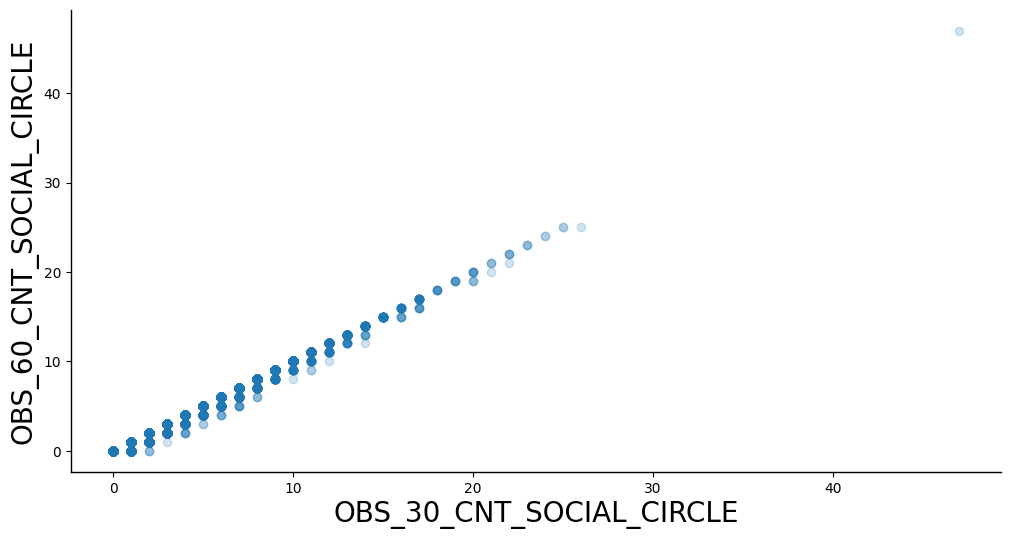

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    sample_application["OBS_30_CNT_SOCIAL_CIRCLE"],
    sample_application["OBS_60_CNT_SOCIAL_CIRCLE"],
    alpha=0.2,
)
ax.set_xlabel("OBS_30_CNT_SOCIAL_CIRCLE", fontsize=20)
ax.set_ylabel("OBS_60_CNT_SOCIAL_CIRCLE", fontsize=20)
Rstyle_spines(ax, lw=1)

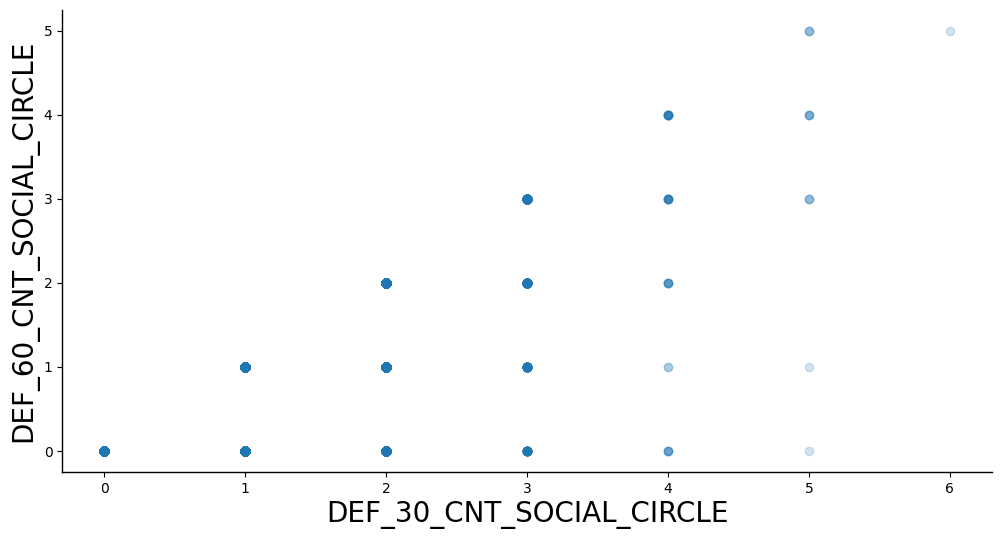

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    sample_application["DEF_30_CNT_SOCIAL_CIRCLE"],
    sample_application["DEF_60_CNT_SOCIAL_CIRCLE"],
    alpha=0.2,
)
ax.set_xlabel("DEF_30_CNT_SOCIAL_CIRCLE", fontsize=20)
ax.set_ylabel("DEF_60_CNT_SOCIAL_CIRCLE", fontsize=20)
Rstyle_spines(ax, lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As observed, both `OBS_60_CNT_SOCIAL_CIRCLE` and `OBS_30_CNT_SOCIAL_CIRCLE` appear to be very similar. Additionally, there seems to be an anomaly in the latter, as some values exceed 30, which raises concerns. Therefore, we will remove `OBS_30_CNT_SOCIAL_CIRCLE` and keep only `OBS_60_CNT_SOCIAL_CIRCLE` for further analysis.

However, for `DEF_60_CNT_SOCIAL_CIRCLE` and `DEF_30_CNT_SOCIAL_CIRCLE`, we do not find enough similarity to justify removing either of them, so we will retain both features in the dataset.
</div>

In [12]:
sample_application.drop("OBS_30_CNT_SOCIAL_CIRCLE", axis=1, inplace=True)
app_num_cols.remove("OBS_30_CNT_SOCIAL_CIRCLE")

#### **Housing Statistics Block**

In [13]:
%%time
app_housing_block_cols = [
    col for col in app_num_cols if col.endswith(("_AVG", "_MODE", "_MEDI"))
]
app_housing_block = sample_application[app_housing_block_cols]
imputer = SimpleImputer(strategy="mean")
# imputer = KNNImputer()

scaler = StandardScaler()
app_housing_block = imputer.fit_transform(app_housing_block)
app_housing_block = scaler.fit_transform(app_housing_block)

CPU times: user 150 ms, sys: 60.4 ms, total: 210 ms
Wall time: 211 ms


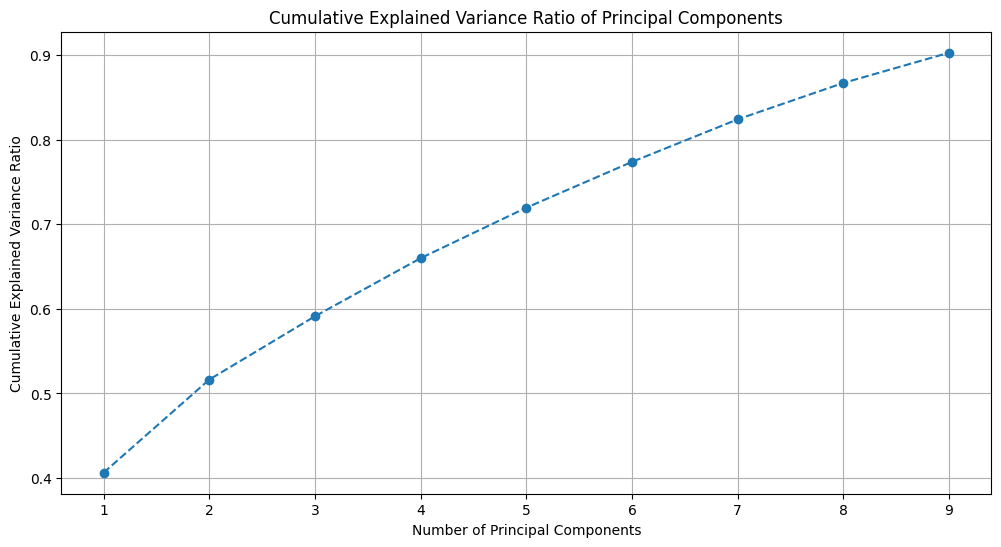

In [14]:
pca = PCA(n_components=0.9)
app_housing_block_pca = pca.fit_transform(app_housing_block)
app_housing_block_pca = app_housing_block_pca.add_prefix("HOUSING_")
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(12, 6))
plt.plot(
    range(1, len(cumulative_variance_ratio) + 1),
    cumulative_variance_ratio,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance Ratio of Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.grid(True)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
We can retain 90% of the total variance by keeping only the first 9 principal components, which will significantly simplify the dataset while preserving most of the important information. For this step, we used a simple imputation method to handle missing values before performing PCA. Although we attempted **KNN imputation**, it was considerably more computationally expensive. However, we may revisit the KNN imputation approach in the future if further improvements in data quality are necessary
</div>

In [15]:
sample_application.drop(columns=app_housing_block_cols, axis=1, inplace=True)
app_num_cols = [item for item in app_num_cols if item not in app_housing_block_cols]
app_num_cols.extend(app_housing_block_pca)
sample_application = pd.concat([sample_application, app_housing_block_pca], axis=1)

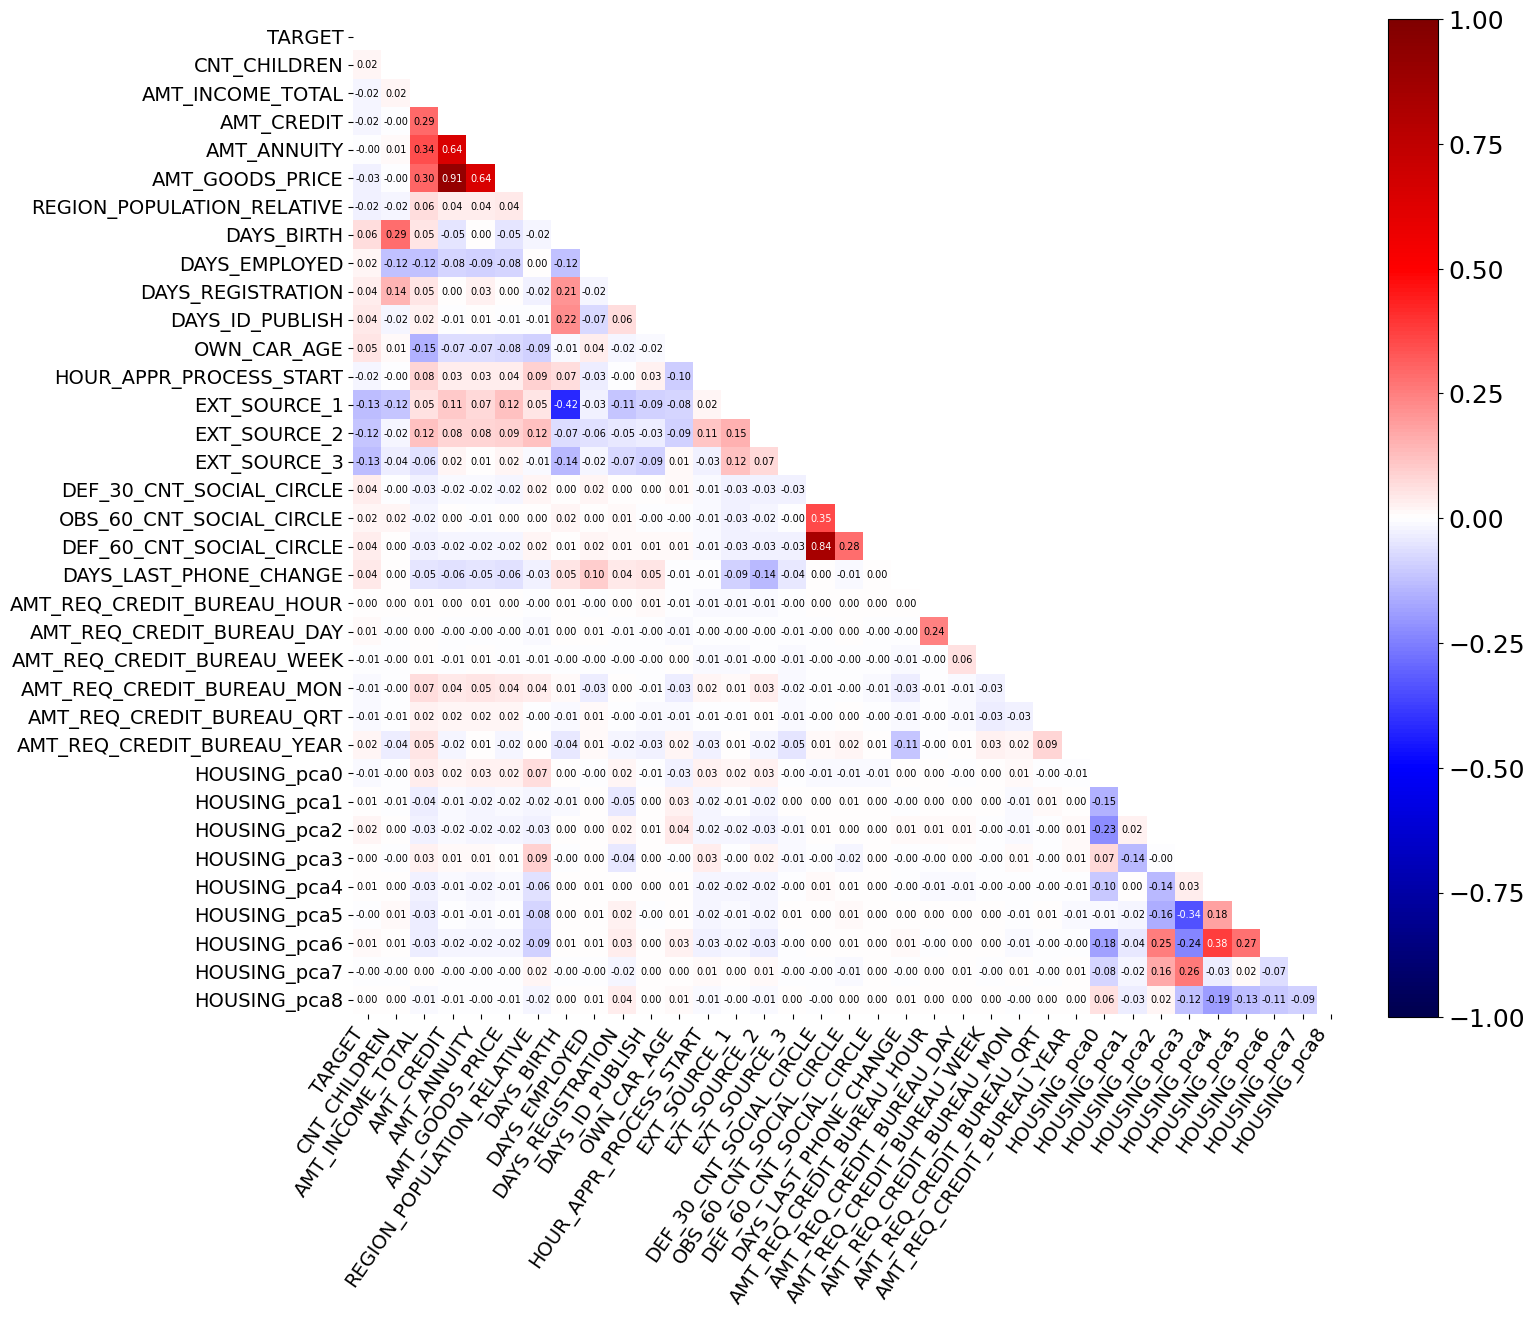

In [16]:
num_corr = sample_application[app_num_cols].corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=14, annotation=True, annot_fs=7)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
By reducing the number of features, we've gained better visibility into the dataset and found fewer highly correlated features. Notably, the three features that exhibit the strongest correlation with the target variable are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`. However, these features contain a substantial number of missing values. To recover as much information as possible, we may need to rely on more advanced imputation techniques, beyond simple imputation, to handle these missing values more effectively and preserve their predictive power.
</div>

#### **Numerical features distribution**

Next, we will plot all the numerical features to gain further insights into their distributions. This will help us identify any anomalies or patterns that might require attention, such as potential outliers to remove or opportunities for feature engineering. For each feature, we will create two plots:

* **Left plot:** The distribution of the entire feature across all instances.
* **Right plot:** The distribution of the feature specifically for instances in the minority class (those who defaulted).
This comparison will allow us to see how these features behave in relation to defaulted applicants, providing clues for potential improvements in our model.

In [17]:
app_num_cols_to_plot = [
    item
    for item in app_num_cols
    if ((item not in ["TARGET", "SK_ID_CURR"]) & (item not in app_housing_block_pca))
]

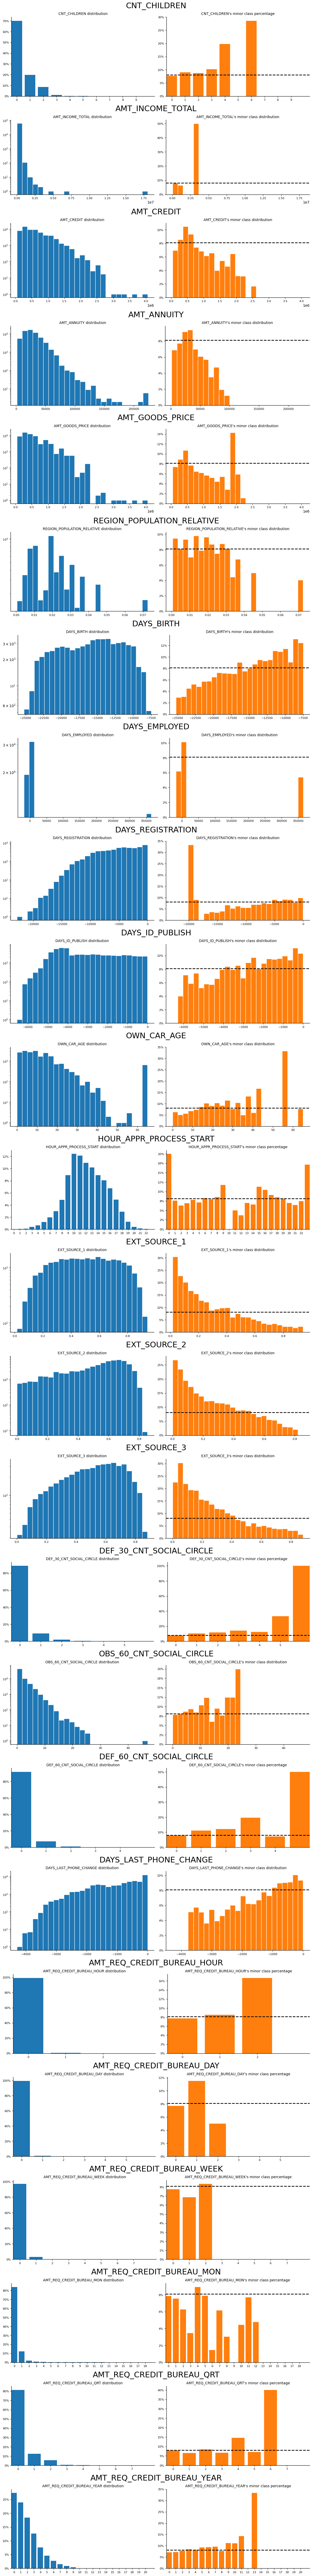

In [18]:
num_rows = len(app_num_cols_to_plot)
fig = plt.figure(layout="constrained", figsize=(12, 4 * num_rows))
subfigs = fig.subfigures(num_rows, 1, wspace=0.07)

for i, feature in enumerate(app_num_cols_to_plot):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(feature, fontsize=22)
    feature_range = np.abs(
        sample_application[feature].max() - sample_application[feature].min()
    )
    if sample_application[feature].nunique() > 30 or feature_range > 30:
        counts_all, bins, _ = axs[0].hist(
            sample_application[feature], bins=25, edgecolor="w", color="C0"
        )

        counts_minor, _ = np.histogram(
            sample_application[sample_application["TARGET"] == 1][feature], bins=bins
        )

        percentages = (
            np.divide(
                counts_minor,
                counts_all,
                out=np.zeros_like(counts_minor, dtype=float),
                where=counts_all != 0,
            )
            * 100
        )
        axs[1].bar(
            bins[:-1],
            percentages,
            width=np.diff(bins),
            align="edge",
            color="C1",
            edgecolor="w",
        )
        Rstyle_spines(axs[0], lw=1)
        Rstyle_spines(axs[1], lw=1)
        axs[0].tick_params(axis="both", which="major", labelsize=8)
        axs[1].tick_params(axis="both", which="major", labelsize=8)
        axs[0].set_title(f"{feature} distribution", fontsize=10)
        axs[1].set_title(f"{feature}'s minor class distribution", fontsize=10)
        axs[0].set_yscale("log")
        axs[1].axhline(y=8.1, ls="--", lw=2, color="k")
        axs[1].yaxis.set_major_formatter(FuncFormatter(to_percent))

    else:
        width = 0.8
        counts = sample_application[feature].value_counts()
        global_percent = 100 * counts / counts.sum()
        target_percent = (
            100
            * sample_application[sample_application["TARGET"] == 1][
                feature
            ].value_counts()
            / counts
        )
        axs[0].bar(x=counts.index.values, height=global_percent, color="C0")
        axs[0].set_xlim(
            (counts.index.min() - width / 2, counts.index.max() + width / 2)
        )
        axs[0].set_xticks(
            np.arange(counts.index.min(), counts.index.max()).astype("int")
        )
        axs[0].tick_params(axis="both", which="major", labelsize=8)
        Rstyle_spines(axs[0], lw=1)
        axs[0].yaxis.set_major_formatter(FuncFormatter(to_percent))

        axs[1].bar(x=counts.index.values, height=target_percent, color="C1")
        axs[1].set_xlim(
            (counts.index.min() - width / 2, counts.index.max() + width / 2)
        )
        axs[1].set_xticks(
            np.arange(counts.index.min(), counts.index.max()).astype("int")
        )
        Rstyle_spines(axs[1], lw=1)
        axs[1].axhline(y=8.1, ls="--", lw=2, color="k")
        axs[1].tick_params(axis="both", which="major", labelsize=8)
        axs[1].yaxis.set_major_formatter(FuncFormatter(to_percent))
        axs[0].set_title(f"{feature} distribution", fontsize=10)
        axs[1].set_title(f"{feature}'s minor class percentage", fontsize=10)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Here are the key observations:
* **`CNT_CHILDREN`:** Most loan applicants have no children (70%). However, applicants with a larger number of children seem more likely to default. It could be useful to rescale the `AMT_INCOME_TOTAL` by the number of children to account for financial burden.
* **`AMT_INCOME_TOTAL`:** There's a large disparity, with some incomes extending beyond 10^7. It's unclear if these are errors or just outliers, as it’s possible some applicants earn that much. Further investigation is needed.
* **`AMT_CREDIT`, `AMT_ANNUITY`, and `AMT_GOODS_PRICE`:** These three are closely related, as expected. There is a notable peak of defaulters for amounts around half a million.
* **`DAYS_BIRTH`:** The current format makes it difficult to interpret. We'll likely rescale all date-related features by dividing them by -1/365 to convert them into years. Younger applicants are more likely to default, possibly due to being students or young workers with limited capital.
* **`DAYS_EMPLOYED`:** Contains anomalies where many entries share the same value. Upon closer inspection, this value seems to be assigned to pensioners or unemployed individuals, so we'll set these to np.nan.
* **`DAYS_REGISTRATION`:** There is a noticeable peak of defaulters among those who changed their registration a very long time ago, suggesting a possible pattern of instability.
* **`OWN_CAR_AGE`:** Applicants with older cars are more likely to default, potentially because they may need to replace their car, adding to their financial burden.
* **`HOUR_APPR_PROCESS_START`:** Applicants who filled out their loan applications late at night are more likely to default. This could suggest rushed or impulsive decision-making.
* **`EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`:** These external scores are highly valuable and strongly correlated with the target. Lower scores are clearly associated with a higher likelihood of default.
* **`DEF_30_CNT_SOCIAL_CIRCLE`, `OBS_60_CNT_SOCIAL_CIRCLE`, and `DEF_60_CNT_SOCIAL_CIRCLE`:** These features tell a similar story: the more defaulters in an applicant’s social circle, the higher the likelihood of the applicant defaulting.
* **`DAYS_LAST_PHONE_CHANGE`:** Surprisingly, people who changed their phones a long time ago are more likely to default. This might indicate financial difficulties or outdated technology.
* **`AMT_REQ_CREDIT_BUREAU`:** As expected, applicants with more inquiries from the Credit Bureau are more likely to default, which may reflect a history of credit problems.
</div>

In [19]:
sample_application.loc[
    sample_application["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"
] = np.nan
sample_application["DAYS_EMPLOYED"] = -sample_application["DAYS_EMPLOYED"] / 365
sample_application["DAYS_BIRTH"] = -sample_application["DAYS_BIRTH"] / 365
sample_application["DAYS_REGISTRATION"] = -sample_application["DAYS_REGISTRATION"] / 365
sample_application["DAYS_ID_PUBLISH"] = -sample_application["DAYS_ID_PUBLISH"] / 365

### **Categorical features**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As mentioned previously, we will now apply a similar approach to the categorical features. Specifically, we will use a combination of the **Chi-squared** test and **Cramér's V** correlation estimation. The Chi-squared test will first help us determine whether there is a significant relationship between the features, by rejecting the null hypothesis that assumes no relationship (black squares in the heatmap below indicate where the null hypothesis is rejected). The statistical significance level $\alpha$ is set to 0.05.

If the **Chi-squared** test indicates a significant relationship, we will calculate **Cramér's V** to quantify the strength of the correlation between the categorical features. This process will help us identify redundant features, allowing us to reduce the number of categorical variables while preserving the most relevant information.
</div>

In [20]:
app_cat_cols = list(sample_application.select_dtypes(include="category").columns.values)
app_cat_cols += [
    col
    for col in sample_application.select_dtypes(include="number").columns
    if col.startswith(("FLAG_", "REG_", "LIVE_", "REGION_RATING_"))
] + ["TARGET"]

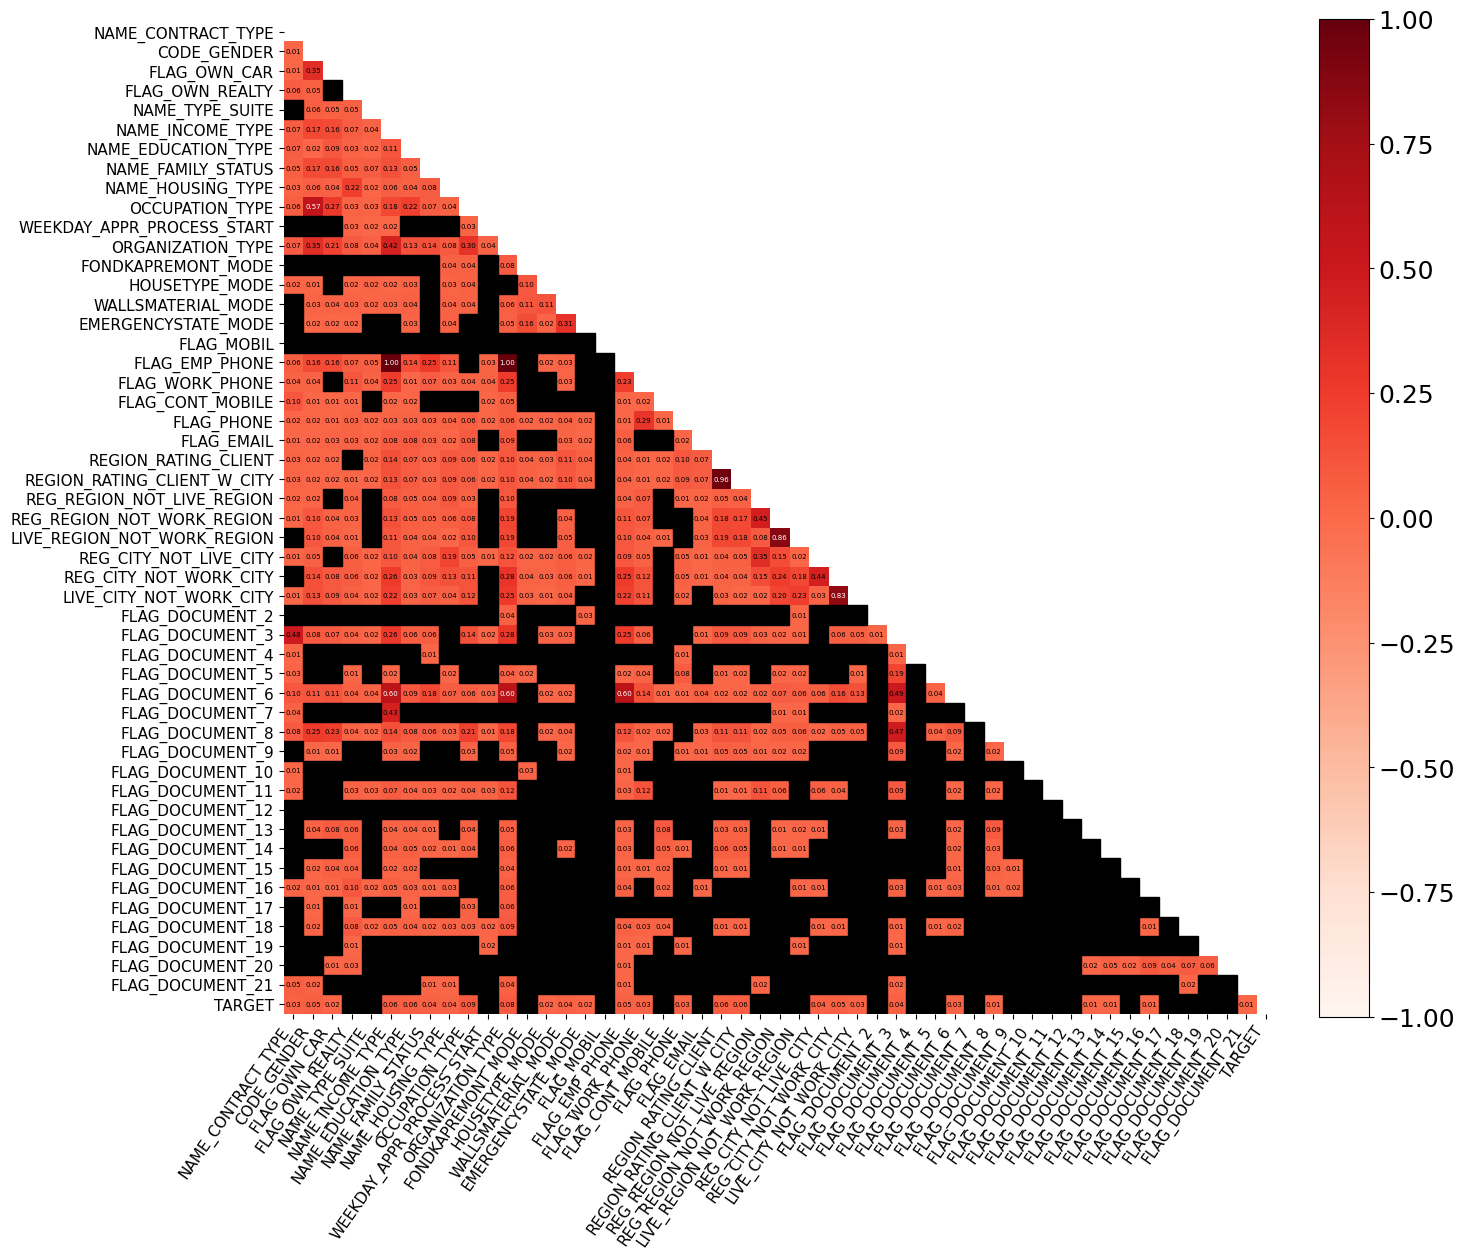

In [21]:
cat_corr = corr_cramersV(sample_application[app_cat_cols])
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(
    cat_corr, ax=ax, ticks_fs=11, annotation=True, annot_fs=5, cramers=True
)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We can observe several rows and columns filled with black tiles, which suggests two possibilities: either the features have no relation to any other, or the features have such low variance that they cannot meaningfully relate to any other. To address this, we will calculate the entropy for each categorical feature to estimate its variability.

Features with an **entropy** below a predefined threshold will be considered as having insufficient variability to be useful, and we will remove them from the dataset. This approach ensures that we retain only the categorical features that contribute meaningful information to the model.
</div>

#### **Entropy**

In [22]:
app_cat_entropy = pd.DataFrame()
app_cat_entropy["Feature"] = app_cat_cols
app_cat_entropy["Entropy"] = [
    calculate_cat_entropy(sample_application[col], normalized=True)
    for col in app_cat_cols
]
app_cat_entropy.sort_values(by="Entropy", ascending=False, inplace=True)

/home/cz/Bureau/TURING/MACHINE_LEARNING/CAPSTONE/home_credit_test/czanko-ML.4.1-master/captsone_test/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cz/Bureau/TURING/MACHINE_LEARNING/CAPSTONE/home_credit_test/czanko-ML.4.1-master/captsone_test/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


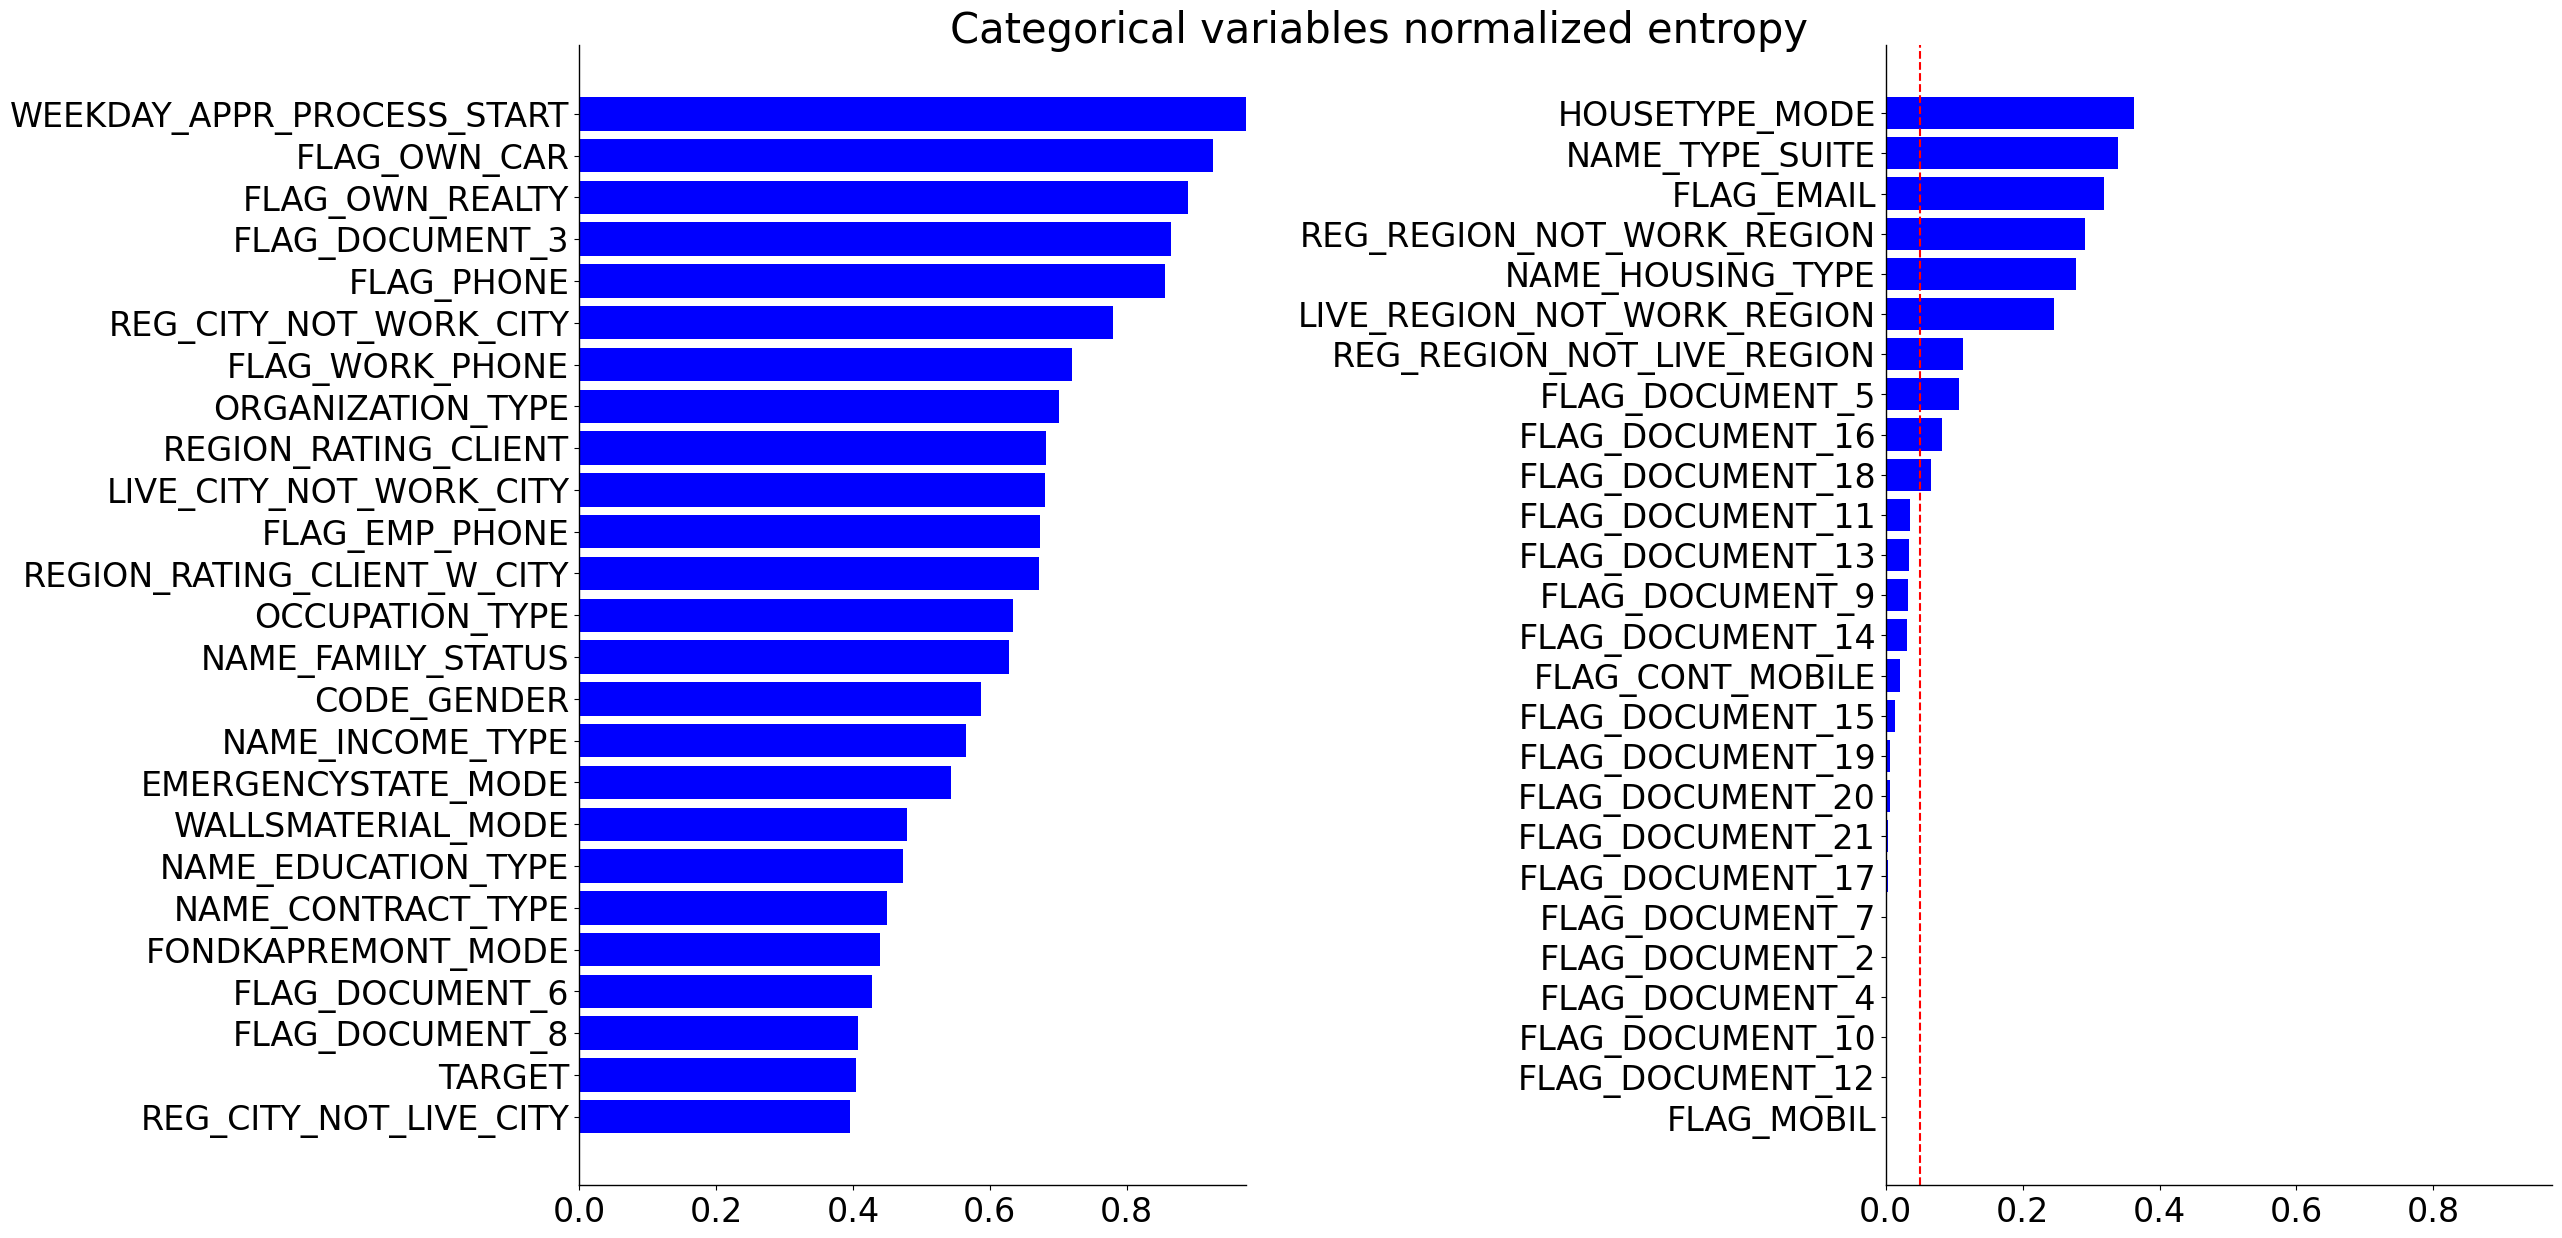

In [23]:
fig = plt.figure(figsize=(16, 12))
axs = multicolumn_barplot(
    app_cat_entropy, fig, y="Feature", width="Entropy", tick_fs=24
)
fig.suptitle("Categorical variables normalized entropy", fontsize=30)
axs[1].axvline(x=0.05, color="red", ls="--", zorder=2)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Some of our categorical features exhibit very low entropy—even 0 for `FLAG_MOBIL`—indicating little to no diversity in the data for these variables. This suggests that they may not provide much useful information for our model, as there is minimal variation to help distinguish between different outcomes.

Removing these low-entropy features should not significantly affect model performance, but it will help in reducing computational cost and enhancing interpretability. By eliminating these redundant features, we streamline the dataset and make it easier to focus on the more informative variables.
<\div>

In [24]:
low_entropy_features = app_cat_entropy[app_cat_entropy["Entropy"] < 0.05]["Feature"]
sample_application.drop(low_entropy_features, axis=1, inplace=True)

In [25]:
app_cat_cols = [col for col in app_cat_cols if not col in low_entropy_features.values]

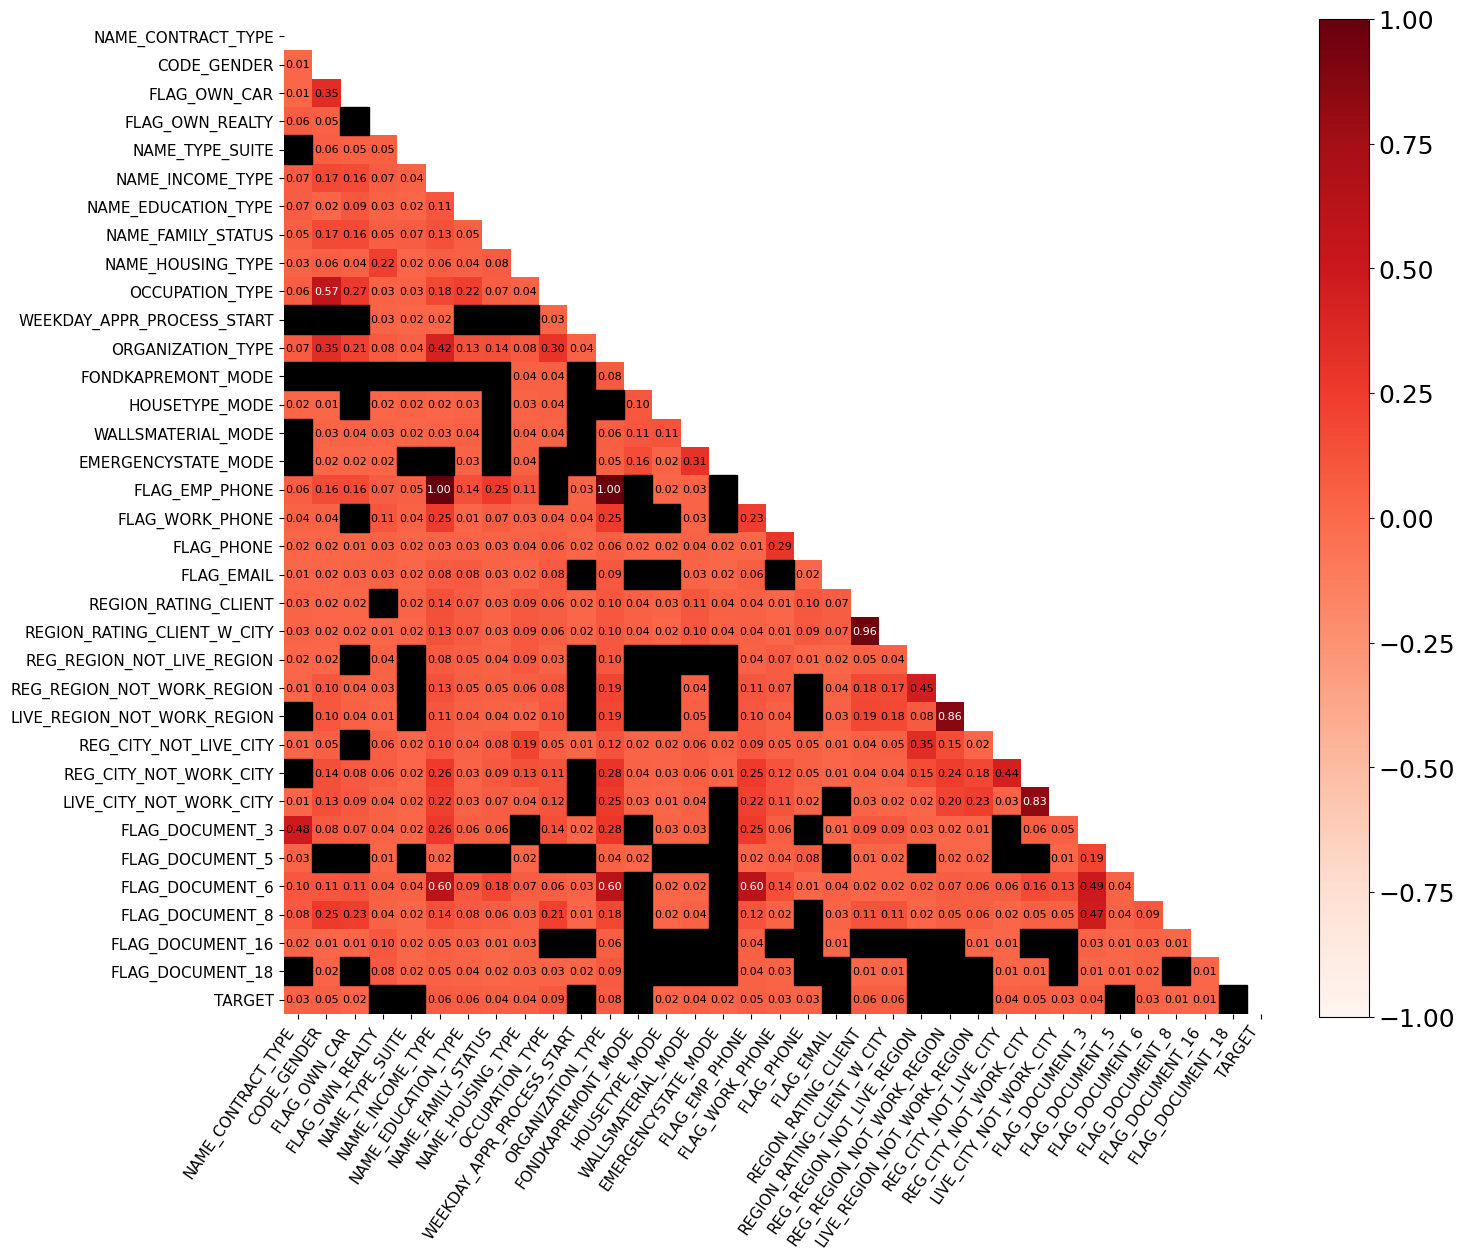

In [26]:
cat_corr = corr_cramersV(sample_application[app_cat_cols])
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(
    cat_corr, ax=ax, ticks_fs=11, annotation=True, annot_fs=8, cramers=True
)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Here are the key observations:
* **`FLAG_EMP_PHONE`:** This feature is likely irrelevant, as it perfectly coincides with `NAME_INCOME_TYPE` and `ORGANIZATION_TYPE`. For instance, pensioners typically don't have an employee phone. Therefore, we will remove `FLAG_EMP_PHONE`.
* **`REGION_RATING_W_CITY` and `REGION_RATING_CLIENT`:** These two features are highly related. Since they are similarly correlated with the target variable, there's no clear choice, but we will remove `REGION_RATING_CLIENT`, as it appears to be less exhaustive than the other.
* **High Cramer's V Scores:** The categorical features most strongly correlated with the target variable are `OCCUPATION_TYPE` and `ORGANIZATION_TYPE`. Both are related to the applicant’s occupation, which ties closely to their financial situation and thus impacts their likelihood of default. These features are important and should be retained for modeling.

These adjustments should enhance our dataset by removing redundant information and focusing on the most valuable features.
</div>

#### **Categorical features distribution**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
We will apply a technique similar to the one used for numerical features to assess how each category within a categorical feature influences the likelihood of a loan applicant defaulting.
* **Left plot:** Will show the distribution of each categorical feature, giving us insight into the prevalence of each category.
* **Right plot:** Will display the percentage of applicants who defaulted for each category, highlighting how specific categories may be associated with a higher risk of default.
This method will help us visually identify patterns and categories that could be key predictors of default.
</div>

In [27]:
removed_cat = list(low_entropy_features.values) + [
    "TARGET",
    "SK_ID_CURR",
    "FLAG_EMP_PHONE",
    "REGION_RATING_CLIENT",
]
app_cat_cols_to_plot = [item for item in app_cat_cols if item not in removed_cat]

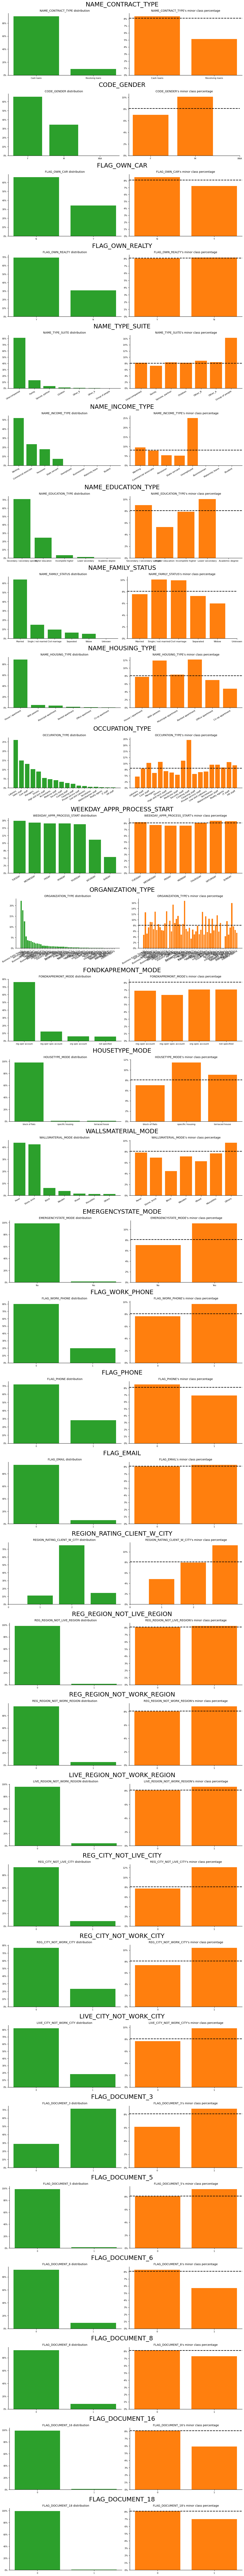

In [28]:
num_rows = len(app_cat_cols_to_plot)
fig = plt.figure(layout="constrained", figsize=(12, 4 * num_rows))
subfigs = fig.subfigures(num_rows, 1, wspace=0.07)

for i, feature in enumerate(app_cat_cols_to_plot):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(feature, fontsize=22)
    width = 0.8
    counts = sample_application[feature].value_counts()
    global_percent = 100 * counts / counts.sum()
    target_percent = (
        100
        * sample_application[sample_application["TARGET"] == 1][feature].value_counts()
        / counts
    )
    axs[0].bar(x=counts.index.values, height=global_percent, color="C2")
    axs[0].tick_params(axis="both", which="major", labelsize=7)
    Rstyle_spines(axs[0], lw=1)
    axs[0].yaxis.set_major_formatter(FuncFormatter(to_percent))
    axs[0].set_xticks(np.arange(0, len(counts)).astype("int"))
    axs[0].set_title(f"{feature} distribution", fontsize=10)

    axs[1].bar(x=counts.index.values, height=target_percent, color="C1")
    Rstyle_spines(axs[1], lw=1)
    axs[1].axhline(y=8.1, ls="--", lw=2, color="k")
    axs[1].tick_params(axis="both", which="major", labelsize=8)
    axs[1].yaxis.set_major_formatter(FuncFormatter(to_percent))
    axs[1].set_title(f"{feature}'s minor class percentage", fontsize=10)
    axs[1].set_xticks(np.arange(0, len(counts)).astype("int"))

    if sample_application[feature].nunique() > 5:
        plt.setp(
            axs[1].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor"
        )
        plt.setp(
            axs[0].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor"
        )

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Here are the key insights we've gathered:
* Applicants with cash loans (the vast majority) have a higher likelihood of default compared to those with revolving loans.
* Male applicants appear more likely to default, even though they represent a minority of the total applicants.
* Applicants accompanied by an indistinct group during their loan process are rare but show a significantly higher likelihood of default.
* Although a small group, unemployed individuals are far more prone to defaulting on their loans.
* Applicants with lower levels of education tend to default more frequently.
* Those who live with their parents or rent an apartment show a higher tendency to default.
* Nearly 20% of applicants working in cooking-related occupations have defaulted, the highest proportion within the OCCUPATION_TYPE feature.
* For the `EMERGENCYSTATE_MODE` feature, applicants who answered "yes" are more likely to default.
* A high `REGION_RATING_CLIENT_W_CITY` score is associated with a greater number of defaults.
* In general, if any FLAG feature is marked as "yes," the applicant is more likely to default.
These observations give us clear patterns that help identify which categories are more strongly associated with loan defaults.
</div>

### **Preliminary model**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Next, we will create a preprocessing pipeline to transform the dataset based on the insights gathered during our Exploratory Data Analysis (EDA). The pipeline will include steps such as:
* **Anomalies Treatment:** Remove or cap outliers in numerical features, as identified in the analysis (e.g., `AMT_INCOME_TOTAL`).
* **Handling Missing Values:** Impute missing values using suitable strategies (e.g., mean, median, or advanced imputation techniques).
Feature Selection: Remove redundant and low-entropy features identified during the EDA.
* **Encoding Categorical Features:** Convert categorical variables into numerical format using techniques like one-hot encoding, ordinal encoding, or target encoding.
* **Dimensionality Reduction:** Apply PCA for feature groups that showed multicollinearity to reduce the number of features while retaining most of the variance.
* **Training classifiers:** After setting up the preprocessing pipeline, we will train different classifiers using only this dataset to get an initial understanding of how well current features can predict whether a loan applicant will default. We can experiment with several algorithms, such as LightGBM, CatBoost, or XGBoost, focusing on metrics like ROC AUC to evaluate performance, given the class imbalance. This initial classifiers will serve as a baseline, giving us insights into how predictive present-time information is for loan default risk.
</div>

In [29]:
train = pd.read_parquet("../sample_data/sample_application.parquet")
X_train = train.drop("TARGET", axis=1)
y_train = train["TARGET"]
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [30]:
housing_block_cols = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "TOTALAREA_MODE",
]

low_entropy_features = [
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_14",
    "FLAG_CONT_MOBILE",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_12",
    "FLAG_MOBIL",
]

cat_features = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "WEEKDAY_APPR_PROCESS_START",
    "ORGANIZATION_TYPE",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
]

numerical_features = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
    "HOUR_APPR_PROCESS_START",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
]

columns_to_drop = low_entropy_features + ["CNT_FAM_MEMBERS", "OBS_30_CNT_SOCIAL_CIRCLE"]

ext_source = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

In [31]:
class RemoveAnomalieRescaleAndDrop(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_.loc[X_["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan
        X_["DAYS_EMPLOYED"] = -X_["DAYS_EMPLOYED"] / 365
        X_["DAYS_BIRTH"] = -X_["DAYS_BIRTH"] / 365
        X_["DAYS_REGISTRATION"] = -X_["DAYS_REGISTRATION"] / 365
        X_["DAYS_ID_PUBLISH"] = -X_["DAYS_ID_PUBLISH"] / 365
        X_.drop(self.columns_to_drop, axis=1)
        return X_

In [32]:
simple_imputer = SimpleImputer(strategy="median")

imputer = ColumnTransformer(
    transformers=[
        ("simple_imputer", simple_imputer, numerical_features + housing_block_cols),
        ("cat_imputer", SimpleImputer(strategy="most_frequent"), cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    n_jobs=-1,
)

In [33]:
scaler = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), numerical_features + housing_block_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    n_jobs=-1,
)

In [34]:
encoder = ColumnTransformer(
    transformers=[
        ("encoder", TargetEncoder(), cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    n_jobs=-1,
)

In [35]:
class PCASelection(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_pca, n_components=0.9):
        self.features_to_pca = features_to_pca
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        self.pca.fit(X[self.features_to_pca])
        return self

    def transform(self, X):
        X_ = X.copy()
        pca_result = self.pca.transform(X_[self.features_to_pca])
        X_ = X_.drop(columns=self.features_to_pca)
        for i in range(pca_result.shape[1]):
            X_[f"PCA_HOUSING_{i+1}"] = pca_result[f"pca{i}"]

        return X_


housing_reduction = ColumnTransformer(
    transformers=[("pca", PCASelection(housing_block_cols), housing_block_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [36]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_["INCOME_CHILDREN_RATIO"] = X_["AMT_INCOME_TOTAL"] / (
            X_["CNT_CHILDREN"] + 0.00001
        )
        X_["CREDIT_INCOME_RATIO"] = X_["AMT_CREDIT"] / (
            X_["AMT_INCOME_TOTAL"] + 0.00001
        )
        X_["CREDIT_ANNUITY_RATIO"] = X_["AMT_CREDIT"] / (X_["AMT_ANNUITY"] + 0.00001)
        X_["ANNUITY_INCOME_RATIO"] = X_["AMT_ANNUITY"] / (
            X_["AMT_INCOME_TOTAL"] + 0.00001
        )
        X_["INCOME_ANNUITY_DIFF"] = X_["AMT_INCOME_TOTAL"] - X_["AMT_ANNUITY"]
        X_["CREDIT_GOODS_RATIO"] = X_["AMT_CREDIT"] / (X_["AMT_GOODS_PRICE"] + 0.00001)
        X_["CREDIT_GOODS_DIFF"] = X_["AMT_CREDIT"] - X_["AMT_GOODS_PRICE"] + 0.00001
        X_["GOODS_INCOME_RATIO"] = X_["AMT_GOODS_PRICE"] / (
            X_["AMT_INCOME_TOTAL"] + 0.00001
        )
        X_["AVG_EXT_SOURCE"] = (
            X_["EXT_SOURCE_1"] + X_["EXT_SOURCE_2"] + X_["EXT_SOURCE_3"]
        ) / 3
        X_["AVG_60_OBS_DEF"] = (
            X_["OBS_60_CNT_SOCIAL_CIRCLE"] + X_["DEF_60_CNT_SOCIAL_CIRCLE"]
        ) / 2

        return X_

In [37]:
polynomial_transformer = PolynomialFeatures(degree=2, include_bias=False)

poly_transformer = ColumnTransformer(
    transformers=[
        (
            "polynomial_transformer",
            polynomial_transformer,
            ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [38]:
preprocessor = Pipeline(
    [
        ("remover", RemoveAnomalieRescaleAndDrop(columns_to_drop)),
        ("imputer", imputer),
        ("scaler", scaler),
        ("housing_reduction", housing_reduction),
        ("feature_engineering", FeatureEngineering()),
        ("poly_transformer", poly_transformer),
        ("encoder", encoder),
    ]
)

In [39]:
classifiers = {
    "LightGBM": LGBMClassifier(class_weight="balanced", verbose=0),
    "CatBoost": CatBoostClassifier(
        class_weights=[1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],
        verbose=0,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        verbosity=0,
    ),
    "Dummy": DummyClassifier(strategy="most_frequent"),
}

In [40]:
classifiers_scores = list(dict())

for key in classifiers.keys():
    pipeline = Pipeline([("preprocessor", preprocessor), (key, classifiers[key])])
    scores = cross_validate(
        pipeline, X_train, y_train, cv=skf, scoring="roc_auc", return_train_score=True
    )
    classifiers_scores.append(
        {
            "classifier": key,
            "train_score": np.mean(scores["train_score"]),
            "test_score": np.mean(scores["test_score"]),
        }
    )

df_scores_first = pd.DataFrame.from_records(classifiers_scores, index="classifier")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [41]:
df_scores_first

train_score  test_score
classifier                         
LightGBM       0.885746    0.741787
CatBoost       0.948614    0.736716
XGBoost        0.963772    0.708051
Dummy          0.500000    0.500000

Text(0, 0.5, 'ROC-AUC')

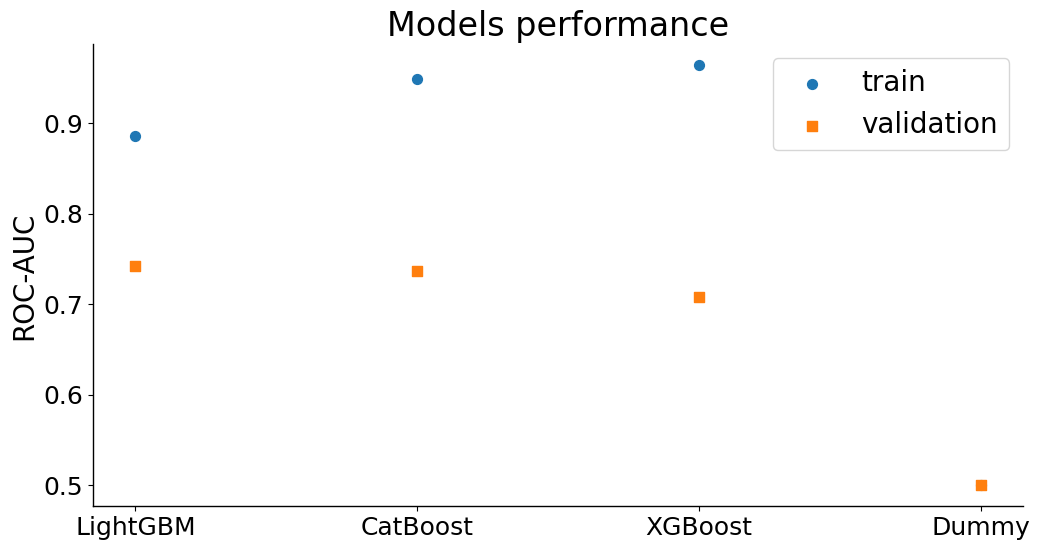

In [42]:
base_cmap = plt.colormaps.get_cmap("Set1")
index_to_color = {index: base_cmap(i) for i, index in enumerate(df_scores_first.index)}

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    df_scores_first.index,
    df_scores_first["train_score"],
    color="C0",
    s=50,
    label="train",
)
ax.scatter(
    df_scores_first.index,
    df_scores_first["test_score"],
    color="C1",
    marker="s",
    s=50,
    label="validation",
)
ax.legend(fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=18)
Rstyle_spines(ax, lw=1)
ax.set_title("Models performance", fontsize=24)
ax.set_ylabel("ROC-AUC", fontsize=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As observed above, using only the application dataframe, we achieved a **ROC AUC score** of **around 0.74** with the **LightGBM** algorithm. While this score isn't optimal (the best models typically achieve around 0.80), it shows that our model already possesses some predictive power (considering the Dummy classifier hovers around 0.5).

However, we noticed that all algorithms we trained—especially CatBoost and XGBoost—show signs of overfitting. This could be due to the large number of features, many of which are likely irrelevant or because of persistent multicollinearity issues. We'll need to address these concerns over time.

Our next step will focus on gathering additional information from the loan applicant's history using the other datasets at our disposal. By conducting further exploratory data analysis, engaging in feature creation and feature engineering, we aim to improve our ROC AUC score. Even a 0.1 increase in the ROC AUC score can translate into significant savings for Home Credit.

While there are other options that could marginally enhance our models, such as fine-tuning encoding techniques or optimizing the preprocessing steps, we will focus on these areas in due time, if needed.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here's a summary of what we've accomplished so far:

* **Thorough Exploratory Data Analysis (EDA) of the Application Dataset:**
    * **Class Imbalance:** Identified the significant class imbalance in the target variable, requiring specific strategies to handle it.
    * **Anomaly Detection:** Detected anomalies in certain features (e.g., DAYS_EMPLOYED) that require special handling.
    * **Feature Relationships:** Gained an understanding of how features relate to each other and the target variable, highlighting areas of multicollinearity and strong correlations.
    * **Feature Reduction:** Initially reduced the number of features by removing those with high correlation or low entropy, simplifying the dataset.
    * **Key Features:** Identified highly predictive features, particularly the EXT_SOURCE variables, which are expected to be crucial in building an effective model.
* **Preliminary Model Building:**
    * **Preprocessing Pipeline:** Began constructing a pipeline to handle imputation, encoding, and scaling of features.
    * **Feature Engineering:** Started creating new features based on the existing ones in the dataset to improve model performance.
    * **Baseline Model Testing:** Tested several classifiers, including LightGBM, CatBoost, and XGBoost, and set an initial baseline for performance. This provides us with a reference point for further improvements using the additional datasets.

We have established a strong foundation with this EDA and preliminary model-building phase, positioning us to enhance our model by leveraging additional datasets.
</div>